# Predicting the price of diamonds
## Phase 2: Statistical Modelling

#### Group Name: Group 32

#### Name(s) & ID(s) of Group Members:
    

#### Mitchell Reid S3901557
####    James McClure S3898327
####    Zachary Pascall S3900372

## Table of Contents
- [Introduction](#intro)
- [Statistical Modelling](#sm)
- [Critique & Limitations](#cl)
- [Summary & Conclusions](#sc)

## Introduction <a id='intro'></a>

### Phase 1 Summary

The report for phase 1 consisted of understanding the dataset variables, deciding to use diamond price as the target variable, then taking cleaning and preprocessing steps to the dataset, which included of note the removal of the 3 variables x, y and z, as we found them redundant while also having the variables table and depth. Further we took a random sample of 30000 rows out of 53940. During data exploration observations of note where that the distribution of diamond prices in the dataset was significantly right-skewed, and that the strongest correlate by far to diamond price was the carat weight variable, with the only other variable showing something of a correlation was diamond clarity. There was also very weak to non-existent correlations between the independant variables, which verified that they are independant. An important assumption we made during Phase 1 was that the prices of diamonds are independant from one another.

The random sampling of the dataset was to reduce calculation times, however we found that the run time was not drastically longer using the full cleaned dataset, so we used the full cleaned dataset instead to increase accuracy.

### Report Overview

Following this introduction section is the statistical modelling section, in which we first perform OLS regression on the dataset, doing diagnostic checks after to check accuracy, then performing backwards feature selection to the dataset (if necessary) and re-running the regression and diagnostic checks on the reduced model, then comparing to the initial model. If necessary we will apply scaling to these models, performing more diagnostic checks and comparing the models fit compared to the previous. After this we will also utilise neural networks to predict diamond price, then comparing that to the other models and analyse the findings.

The folowing section, Critique & Limitations, will evaluate in detail the possible shortcomings and issues to the approach  we took and in what way and how much they may have affected the findings, if at all. Finally, the last section will summarise both Phase 1 and Phase 2 reports as a whole, summarise all the findings of both, and conclude about the project with regards to the initial goals and objectives set out in Phase 1.

### Overview of Methodology

For fitting the model one of the larger changing to the dataset was one-hot encoding the categorical variables into binary variables for each category label, as so it would function better using our regression type, being multiple linear regression. Using multiple linear regression we can create a model to predict the dependant variable (diamond price) against multiple independant variables. We will use OLS (ordinary least squares) regression to reduce the square of errors in the model, which helps give a more accurate regression line. the equation used for the predicted value of diamond price would follow a formula of (predicted price) = (intercept estimate) + (coefficent of variable B)(variable A) + (coefficent of variable B)(variable B) etc. The values of intercept and coefficient of an independent variable are calculated by statsmodel.api. The statsmodel.api module also calculates p values, the r value and the r squared value for a model, which help indicate the accuracy of the model. The r value indicates the correlation between the observed value of the dependant variable (price) and the predicted value for it, with a value between 0 and 1 with 1 being the highest correlation. The r squared value indicates the proportion of the variance that can be explained by the independant variables in the model with 0 being 0% of the variance and 1 being 100%. The p value indicates how likely you would find an observed set of values given a null hypothesis. In this case, our null hypothesis is that the test score is equal to 0, hence a low p value would mean this is unlikely, which indicates accuracy if the test score violates this null hypothesis. For our testing purposes, we will consider a p value as significant if it is less than 0.05. After running these tests with statsmodel.api, we will perform diagnostic checks to determine if it violates any of the assumptions of multiple linear regression, which are as follows:
* The residuals should be nearly normal
* The residuals should have a constant variability
* The residuals are independent
* Each variable should be linearly related to the outcome

From there, if we see it fit, we may apply scaling to the graph and perform the previous steps, then comparing the results with the previous model.
If it is required, we will also perform feature selection, in which we will perform the previous steps, however with variables removed that have p values over our specified significance level (0.05). We will then compare the results with the previous models and their results.

A detailed, complete, and accurate overview of your statistical modelling methodology (which is multiple linear regression).

## Statistical Modelling <a id='sm'></a>

### Full Model Overview

Overview of full model, including the variables and terms you are using in your regression model.

Our model will predict the sale price of a diamond based on factors such as its weight (carat), cut, colour, clearness, and dimension ratio. For a full explanation of each variable, please see our Phase 1 report.

#### Module Imports

First, we import all our required libraries and load our cleaned data. We can see a sample of the data as well.

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

df = pd.read_csv('diamonds_cleaned_no_sampling.csv')
df.head()

,carat,cut,color,clarity,depth,table,price
0,0.23,Ideal,E,SI2,61.5,55.0,326
1,0.21,Premium,E,SI1,59.8,61.0,326
2,0.23,Good,E,VS1,56.9,65.0,327
3,0.29,Premium,I,VS2,62.4,58.0,334
4,0.31,Good,J,SI2,63.3,58.0,335


#### Full Model Fitting

Details of assumptions check, model selection, plots of residuals, and technical analysis of regression results.

**NOTE:** The second half of [this](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb) regression case study ("Statistical Modeling and Performance Evaluation" Section) will be **very helpful** for this Model Fitting section.

Much of the data in our model is still categorical. We must first one-hot encode this data in order to fit it to a model effectively.

In [174]:
df_enc = pd.get_dummies(df)
df_enc.sample(10, random_state=405)

,carat,depth,table,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
36187,0.41,63.0,57.0,931,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
51096,0.71,62.3,63.0,2335,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2414,0.87,62.2,57.0,3180,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2136,0.71,61.8,56.1,3123,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
47156,0.45,61.8,55.0,1833,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
11719,0.34,61.4,54.0,596,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
51509,0.74,59.2,60.0,2383,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
27566,2.40,62.0,55.0,18374,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
33746,0.31,62.0,55.0,840,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
35068,0.32,61.5,56.0,886,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


Some of our column names also contain spaces. The statsmodels module does not behave well with columns with spaces, so we will remove them:

In [175]:
for col in df_enc.columns:
    col_cont = df_enc[col]
    df_enc = df_enc.drop(col, 1)
    col = col.replace(' ', '_')
    df_enc[col] = col_cont
    
df_enc.head()

,carat,depth,table,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very_Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


Then, we create a formula string to create our initial full model, including all our newly created one-hot encoded columns:

In [176]:
formula = 'price ~ ' + ' + '.join(df_enc.drop(columns='price').columns)
print(f'Formula string: {formula}')

Formula string: price ~ carat + depth + table + cut_Fair + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_D + color_E + color_F + color_G + color_H + color_I + color_J + clarity_I1 + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2


Now, we can construct and fit the full model for our dataset using OLS (ordinary least squares):

In [177]:
model_full = sm.formula.ols(formula=formula, data=df_enc)
model_full_fit = model_full.fit()
print(model_full_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 2.942e+04
Date:                Sun, 24 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:20:46   Log-Likelihood:            -4.5696e+05
No. Observations:               53940   AIC:                         9.140e+05
Df Residuals:                   53919   BIC:                         9.141e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -660.5964    245.550     -2.690

#### Full Model Diagnostic Checks

We should verify that there are no violations to our assumptions for performing a multiple linear regression. These assumptions are:
* The residuals should be nearly normal
* The residuals should have a constant variability
* The residuals are independent
* Each variable should be linearly related to the outcome

To test this, we will first extract the the actual price, predicted price, and residual for each of our datapoints: 

In [178]:
residuals_full_model = pd.DataFrame({'actual': df_enc['price'], 
                        'predicted': model_full_fit.fittedvalues, 
                        'residual': model_full_fit.resid})
residuals_full_model.head(5)

,actual,predicted,residual
0,326,-1880.655358,2206.655358
1,326,-1294.390550,1620.390550
2,327,-388.723319,715.723319
3,334,-1148.056007,1482.056007
4,335,-3656.151582,3991.151582


Now, we can plot a actual vs. predicted plot:

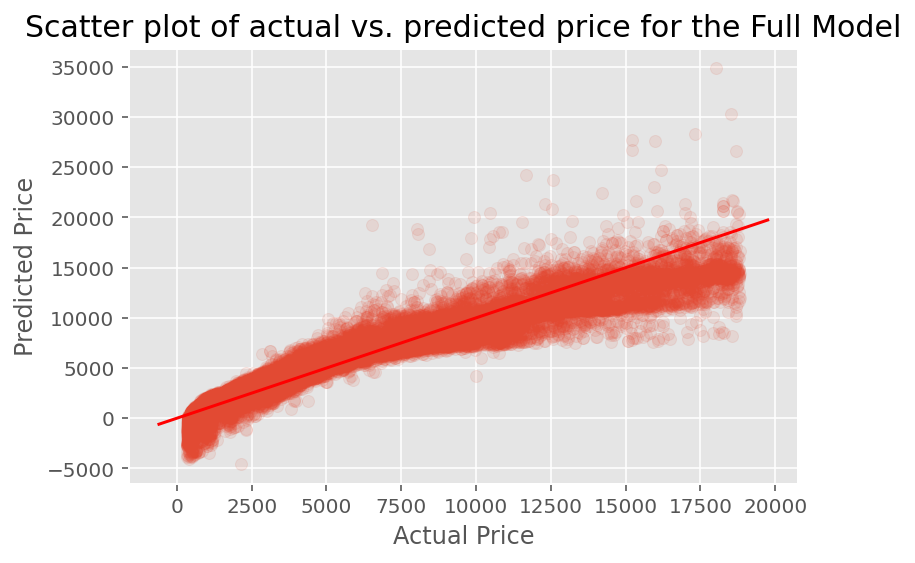

In [179]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_full_model['actual'], residuals_full_model['predicted'], alpha=0.1);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Price');
plt.ylabel('Predicted Price');
plt.title('Scatter plot of actual vs. predicted price for the Full Model', fontsize=15);
plt.show();

The variability seems to be close, but not perfectly, constant. As the graph shows, the number of outliers tends to increase as the actual price increases. Let's have a look at a variance graph to determine how severe this is.

#### Applying scaling

Interestingly, the trend of the graph seems to follow a `predicted=a*sqrt(actual)` trend. This might indicate that our model would have better results if we applied a square root scaling factor to our target feature. Let's test this before continuing with our analysis:

In [180]:
df_enc_scaled = df_enc.copy()
df_enc_scaled['price'] = np.sqrt(df_enc_scaled['price'])
df_enc_scaled = df_enc_scaled.rename(columns={'price': 'sqrt_price'})

formula_scaled = 'sqrt_price ~ ' + ' + '.join(df_enc_scaled.drop(columns='sqrt_price').columns)

In [181]:
model_full_scaled = sm.formula.ols(formula=formula_scaled, data=df_enc_scaled)
model_full_scaled_fit = model_full_scaled.fit()
print(model_full_scaled_fit.summary())

                            OLS Regression Results                            
Dep. Variable:             sqrt_price   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 5.130e+04
Date:                Sun, 24 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:20:46   Log-Likelihood:            -1.7667e+05
No. Observations:               53940   AIC:                         3.534e+05
Df Residuals:                   53919   BIC:                         3.536e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.0843      1.360      2.268

Our R-squared values have increased slightly, which is a good sign. Let's check our diagnostic graphs to confirm we have improved our model:

#### Scaled model diagnostic checks

Our aim with these diagnostic checks is twofold: First, to determine whether the scaling has improved the model compared to not scaling, and then to determine whether the model follows the requirements for a linear regression laid our above.

As before, we will first construct a new DataFrame to store our residuals:

In [182]:
residuals_full_model_scaled = pd.DataFrame({'actual': df_enc_scaled['sqrt_price'], 
                                'predicted': model_full_scaled_fit.fittedvalues, 
                                'residual': model_full_scaled_fit.resid})
residuals_full_model_scaled.head(5)

,actual,predicted,residual
0,18.055470,14.396725,3.658745
1,18.055470,18.568294,-0.512824
2,18.083141,25.116480,-7.033339
3,18.275667,17.865363,0.410304
4,18.303005,2.832657,15.470348


Then, let us check a new actual vs. predicted plot for the scaled model beside the unscaled model:

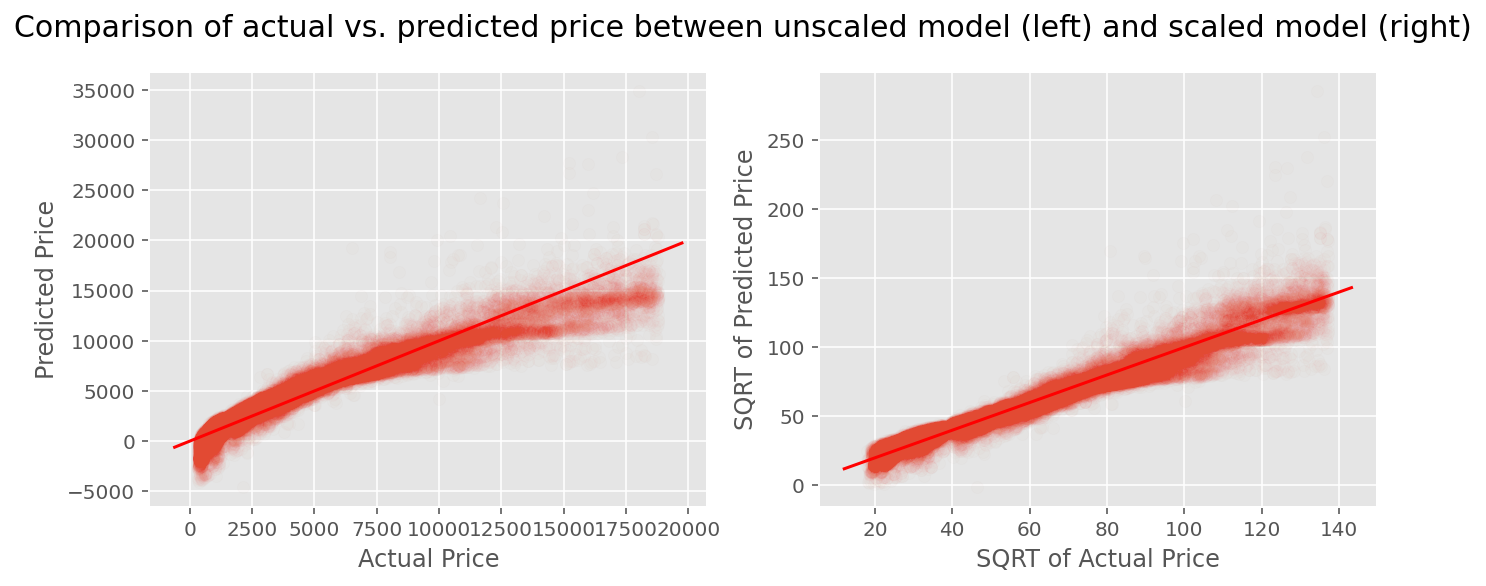

In [183]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    axis.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Show two graphs at once
fig, axs = plt.subplots(1, 2, figsize=[11, 4])
    
# Creating scatter plot for scaled model
axs[1].scatter(residuals_full_model_scaled['actual'], residuals_full_model_scaled['predicted'], alpha=0.01);
plot_line(axis=axs[1], slope=1, intercept=0, c="red");
axs[1].set_xlabel('SQRT of Actual Price');
axs[1].set_ylabel('SQRT of Predicted Price');

# Creating scatter plot for unscaled model
axs[0].scatter(residuals_full_model['actual'], residuals_full_model['predicted'], alpha=0.01);
plot_line(axis=axs[0], slope=1, intercept=0, c="red");
axs[0].set_xlabel('Actual Price');
axs[0].set_ylabel('Predicted Price');

fig.suptitle('Comparison of actual vs. predicted price between unscaled model (left) and scaled model (right)', fontsize=15);
plt.show();

As we can see, the new graph seems to have improved our model's fit to a linear relationship. It also appears to have made the variance across our graph more constant. It also eliminated the negative predictions our model was making of low-value diamonds. 

Now, let us perform a more detailed check as to whether the variance has been made more constant with a dedicated variance graph:

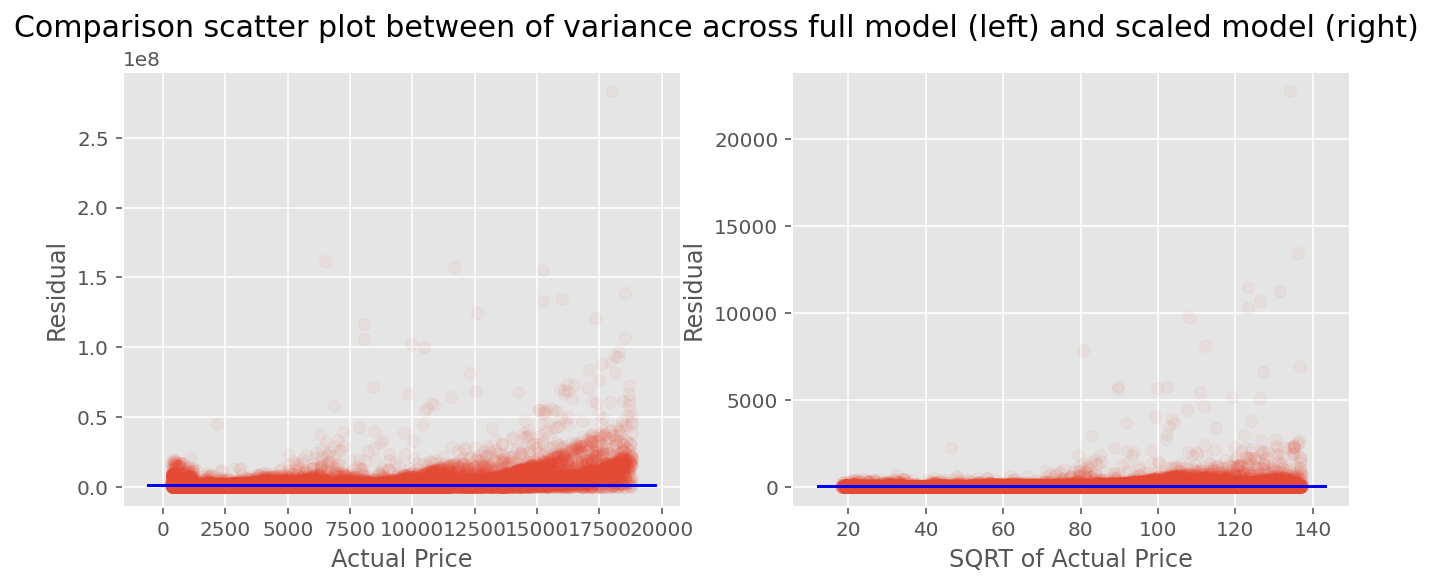

In [184]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    axis.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)

# Show two graphs at once
fig, axs = plt.subplots(1, 2, figsize=[11, 4])
    
# Creating scatter plot
axs[0].scatter(residuals_full_model['actual'], residuals_full_model['residual']**2, alpha=0.05);
plot_line(axis=axs[0], slope=0, intercept=np.average(residuals_full_model['residual']**2), c="blue");
axs[0].set_xlabel('Actual Price');
axs[0].set_ylabel('Residual');

axs[1].scatter(residuals_full_model_scaled['actual'], residuals_full_model_scaled['residual']**2, alpha=0.05);
plot_line(axis=axs[1], slope=0, intercept=np.average(residuals_full_model_scaled['residual']**2), c="blue");
axs[1].set_xlabel('SQRT of Actual Price');
axs[1].set_ylabel('Residual');

fig.suptitle('Comparison scatter plot between of variance across full model (left) and scaled model (right)', fontsize=15);
plt.show();

Taking the blue line as the average variance across each graph, we can see that taking the square root has made our variability more constant. Once we took the root of the price, our variance is almost constant, with only a slight uptick in outliers towards the top of the graph. This therefore can be said to satisfy the requirement for constant variability 

Let us also view the a comparison histogram of the residuals to confirm they are nearly normal:

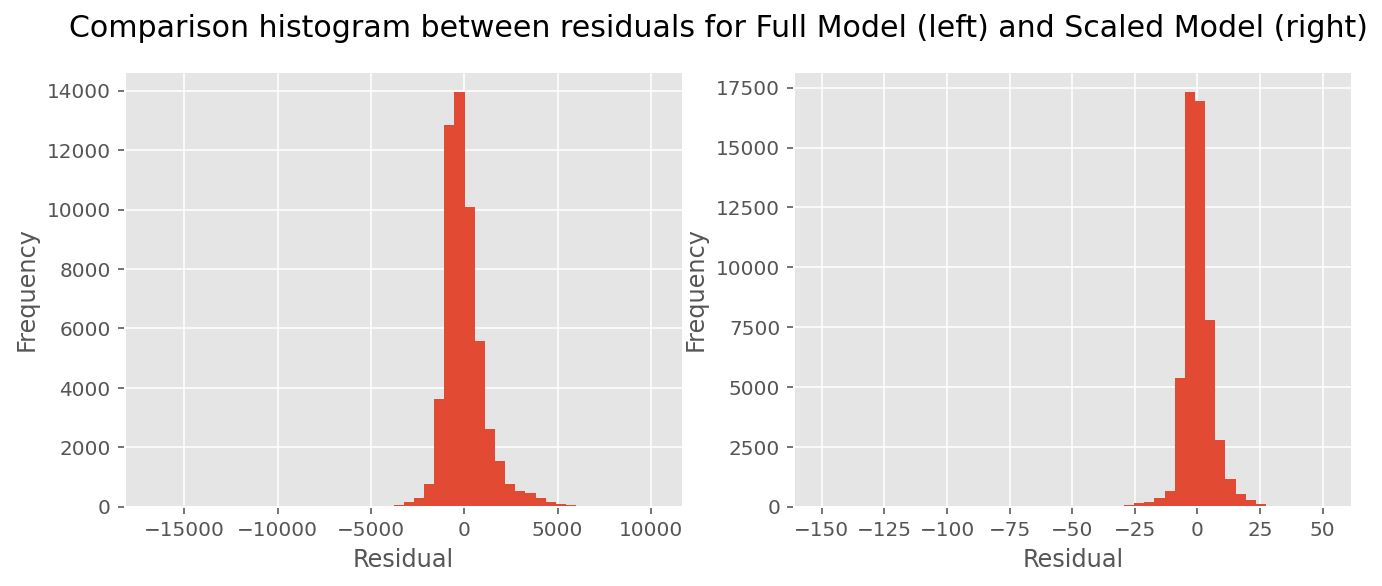

In [185]:
# Show two graphs at once
fig, axs = plt.subplots(1, 2, figsize=[11, 4])

axs[0].hist(residuals_full_model['residual'], bins = 50);
axs[0].set_xlabel('Residual');
axs[0].set_ylabel('Frequency');

axs[1].hist(residuals_full_model_scaled['residual'], bins = 50);
axs[1].set_xlabel('Residual');
axs[1].set_ylabel('Frequency');

fig.suptitle('Comparison histogram between residuals for Full Model (left) and Scaled Model (right)', fontsize=15);
plt.show();

While these graphs are more similar than our previous comparisons, there is still a difference. Scaling our target variable has reduced the skew in the graph, leading to a more symmetric graph. This means that the residuals more closely follow a normal distribution. This indicates an improvement in our model, and also ensures we follow the assumption of the residuals being nearly normal

### Feature Selection

Our initial R-squared value is quite high, at 0.950, explaining 95% of the variance in our model. However, we can see a few of our variables, such as table, have p values that are insignificant at 0.05 level. Therefore, we will use backwards feature selection to improve our model by removing variables with the highest p-values.

We will use the preprepared code below to to perform backward feature selection using p-values ([credit](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb)).

In [186]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_scaled)

# initialize feature-selected fit to full model
linreg_fit = model_full_scaled_fit

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
#     print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=df_enc_scaled).fit()
    
###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula = patsy_description, data = df_enc_scaled).fit()
###
    
#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "table" with p-value 0.9712

***
                            OLS Regression Results                            
Dep. Variable:             sqrt_price   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 5.400e+04
Date:                Sun, 24 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:20:49   Log-Likelihood:            -1.7667e+05
No. Observations:               53940   AIC:                         3.534e+05
Df Residuals:                   53920   BIC:                         3.536e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------

####  Reduced Model Overview

The features used in this model are all the same as was listed in our analysis of the dataset in Phase 1, with the obvious only exception being price, which has been removed in favour of a scaled replacement, sqrt_price, which is the new target variable

#### Reduced Model Diagnostic Checks

You need to check whether there are indications of violations of the regression assumptions for the reduced model.

In [187]:
residuals_reduced_model = pd.DataFrame({'actual': df_enc_scaled['sqrt_price'], 
                        'predicted': model_reduced_fitted.fittedvalues, 
                        'residual': model_reduced_fitted.resid})
residuals_reduced_model.head(5)

,actual,predicted,residual
0,18.055470,14.396133,3.659337
1,18.055470,18.569245,-0.513775
2,18.083141,25.118560,-7.035419
3,18.275667,17.865408,0.410259
4,18.303005,2.832628,15.470378


Scatter plot of real vs. predicted

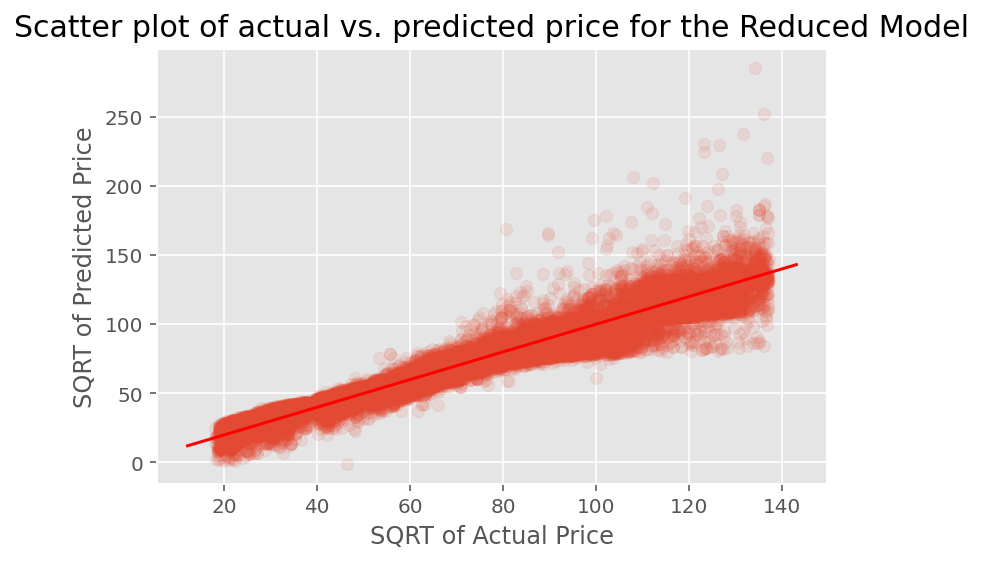

In [188]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_reduced_model['actual'], residuals_reduced_model['predicted'], alpha=0.1);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('SQRT of Actual Price');
plt.ylabel('SQRT of Predicted Price');
plt.title('Scatter plot of actual vs. predicted price for the Reduced Model', fontsize=15);
plt.show();

Scatter plot of variance:

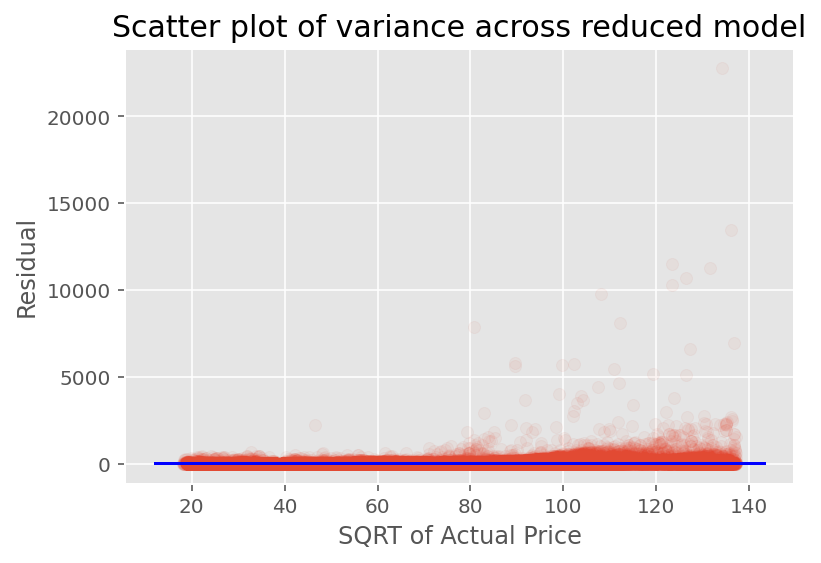

In [189]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_reduced_model['actual'], residuals_reduced_model['residual']**2, alpha=0.05);
plot_line(axis=plt.gca(), slope=0, intercept=np.average(residuals_reduced_model['residual']**2), c="blue");
plt.xlabel('SQRT of Actual Price');
plt.ylabel('Residual');
plt.title('Scatter plot of variance across reduced model', fontsize=15);
plt.show();

Histograms of residuals:

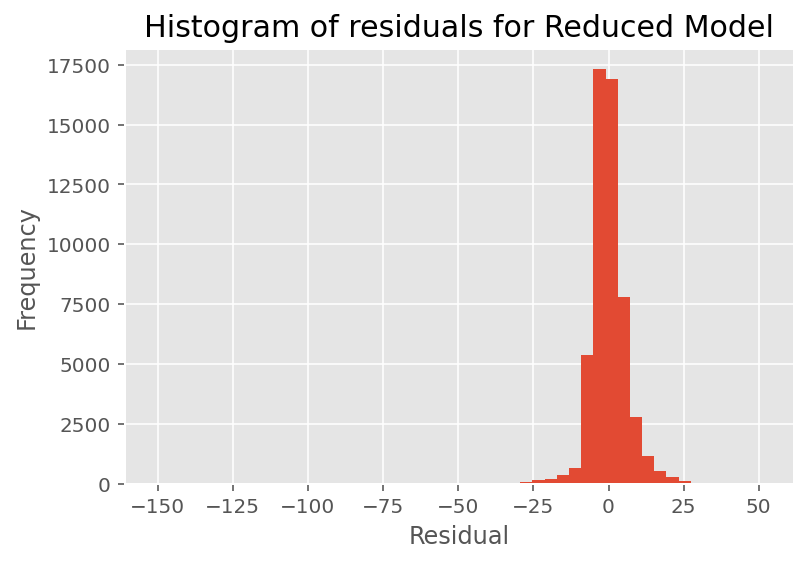

In [190]:
plt.hist(residuals_reduced_model['residual'], bins = 50);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Histogram of residuals for Reduced Model', fontsize=15);
plt.show();

### Neural Net Model Fitting

In addition to the multiple linear regression, we will be producing a neural net to attempt to predict the price of diamonds as well. For this, we will be using [this](https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-7-neural-networks-simple-case-study/) case study as a basis for our parameters.

The first step is to import any additional libraries required to develop a neural net, and copy our original DataFrame:

In [191]:
import sklearn.preprocessing
import sklearn.model_selection
import tensorflow
import tensorflow.keras

nn_df = df_enc.copy()
nn_df.head()

,carat,depth,table,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very_Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


Next, let us split the DataFrame into two separated ones: one for the target, and one for the data:

In [192]:
# data = df.drop(columns=['target'])
# target = df['target'].values.reshape(-1, 1)

data = nn_df.drop(columns=['price'])
target = nn_df['price'].values.reshape(-1, 1)

Next, we need to scale all of our variables to be between 0 and 1, in order to be compatible with our neural net:

In [193]:
data_scaled = sklearn.preprocessing.MinMaxScaler().fit(data.values).transform(data.values)
target_scaled = sklearn.preprocessing.MinMaxScaler().fit(target).transform(target)

Next, we will randomly split our dataset into two smaller ones, with 70% being used for training, and 30% being used for validation.

In [194]:
data_train, data_val, t_train, t_val, idx_train, idx_val = \
    sklearn.model_selection.train_test_split(data_scaled, \
    target_scaled, data.index, test_size=0.3, random_state=404)

Now, we will define our settings for this neural net training. Most are taken directly from the case study we based this on, but there are a few differences:
* The loss function has been converted to mean_squared_error, since unlike the case study this is a regression problem, rather than a categorisation problem. The mean_squared_error function has been chosen based on the article [here](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)
* The metric output has also been switched to mean_squared_error. This is because the accuracy metric does not work for regression problems, since it counts the proportion of cases where the predicted value almost exactly matches the actual value ([Reference](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy)). When predicting large continuous ranges such as this one, the predicted value almost never *exactly* predicts the data, leading to misleadingly low accuract values. Instead, we have opted to use mean_squared_error, as this can be converted into an R<sup>2</sup> value when graphing with relative ease.
* The output activation function has been switched to ReLu, rather than sigmoid. This is, again, because unlike the case study, this problem is predicting a continuous variable rather than a binary one, so sigmoid was unsuited.
* Finally, the epochs have been reduced, since higher numbers take longer to train, and are broadly unnecessary, since most models will, if not fully then be extremely close to, fully optimising by around 300 epochs, based on trial and error when exploring the problem.

In [195]:
# size of the network is determined by the number of neural units in each hidden layer
layer1_units = 4
layer2_units = 4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import mean_squared_error

loss = 'mean_squared_error' 
# during training, we would like to monitor accuracy
metrics = [mean_squared_error]
epochs = 300
batch_size = 100
layer1_activation = 'relu'
layer2_activation = 'relu'
output_activation = 'relu'
layer1_dropout_rate = 0.05
layer2_dropout_rate = 0.00
learning_rate=0.01
decay=1e-6
momentum=0.5
# SGD stands for stochastic gradient descent
optimizer = SGD(lr=learning_rate, decay=decay, momentum=momentum)

Next, we define our model creator function. This function uses the parameters layed out above and returns a model based on them. The architecture of our model is defined here, and will be two dense layers, each with a dropout layer, and a single output.

In [196]:
# set up an empty deep learning model
def model_factory(input_dim, layer1_units, layer2_units):
    model = Sequential()
    model.add(Dense(layer1_units, input_dim=input_dim, activation=layer1_activation))
    model.add(Dropout(layer1_dropout_rate))
    model.add(Dense(layer2_units, activation=layer1_activation))
    model.add(Dropout(layer2_dropout_rate))
    model.add(Dense(1, activation=output_activation))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

Next, we define a plotting function to visualise the performance. We calculate the R<sup>2</sup> value based off the mean squared error, then plot that. For comparison between models when attempting to optimise, we also print our the final R<sup>2</sup> values after plotting.

In [197]:
# define plot function for the fit
# we will plot the accuracy here
def plot_history(history, training_data, validation_data): 
    training_data_total_variance = np.mean(np.power(training_data - np.average(training_data), 2))
    validation_data_total_variance = np.mean(np.power(validation_data - np.average(validation_data), 2))

    r_squared_training = 1 - (history.history['mean_squared_error'] / training_data_total_variance)
    r_squared_validation = 1 - (history.history['val_mean_squared_error'] / validation_data_total_variance)

    plt.plot(r_squared_training)
    plt.plot(r_squared_validation)
    plt.title('Model R^2 value')
    plt.ylabel('R^2')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()

    print(f'Final R^2 training: {r_squared_training[-1]}')
    print(f'Final R^2 validation: {r_squared_validation[-1]}')

Finally, we can create and run our model.

In [198]:
model_test = model_factory(data.shape[1], layer1_units, layer2_units)
history_test = model_test.fit(data_train, 
                              t_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0, # set to 1 for iteration details, 0 for no details
                              shuffle=True,
                              validation_data=(data_val, t_val)
                              # validation_split = 0.2
)

Now we have a trained model, we can plot the performance of the model with our plot function:

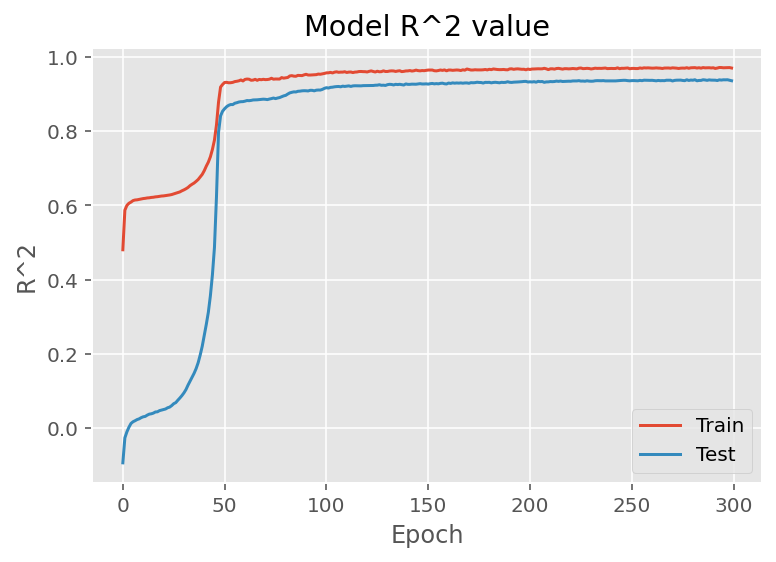

Final R^2 training: 0.9697339670995044
Final R^2 validation: 0.9354797840975103


In [199]:
plot_history(history_test, data_val, t_val)

## Critique & Limitations <a id='cl'></a>

Critique & Limitations of your approach: strengths and weaknesses in detail.

## Summary & Conclusions <a id='sc'></a>

### Project Summary

A comprehensive summary of your entire project (both Phase 1 and Phase 2). That is, what exactly did you do in your project? (Example: I first cleaned the data in such and such ways. And then I applied multiple linear regression techniques in such and such ways. etc).

### Summary of Findings

A comprehensive summary of your findings. That is, what exactly did you find about your particular problem?

### Conclusions

Your detailed conclusions as they relate to your goals and objectives.